# <div style="text-align: center;"> **XGBOOST MODELS** </div>

--------------

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../scr'))
from import_images import create_image_dataset
from image_preprocesser import preprocess_image, apply_preprocessing
from extract_features import extract_features
import tensorflow as tf
from keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score


2025-03-11 14:29:13.265635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741699753.287535 2233086 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741699753.293348 2233086 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 14:29:13.319870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Directories 
train_dir = "../Data/Processed/ml-dp/train"
val_dir = "../Data/Processed/ml-dp/val"
test_dir = "../Data/Processed/ml-dp/test"

### **Load and Preprocessing images**

In [3]:
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None, image_size = (224, 224))
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None, image_size = (224, 224))
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None, image_size = (224, 224))
class_names = train_ds.class_names

Found 2455 files belonging to 2 classes.


I0000 00:00:1741699761.383473 2233086 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4791 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [4]:
#Preprocessing images
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255 
)

### **Pretrained network VGG16**

In [5]:
conv_base_VGG16 = VGG16(weights='imagenet', #Charging the pre-trined weights of VGG16 models with  ImageNet dataset
                  include_top=False, #This option indicates that the last layers (fully connected layers) used for final classification don't be imported
                  input_shape=(224, 224, 3)) #This CNN is optimized with a 224x224 resolution

conv_base_VGG16.trainable = False #freezing layers

conv_base_VGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

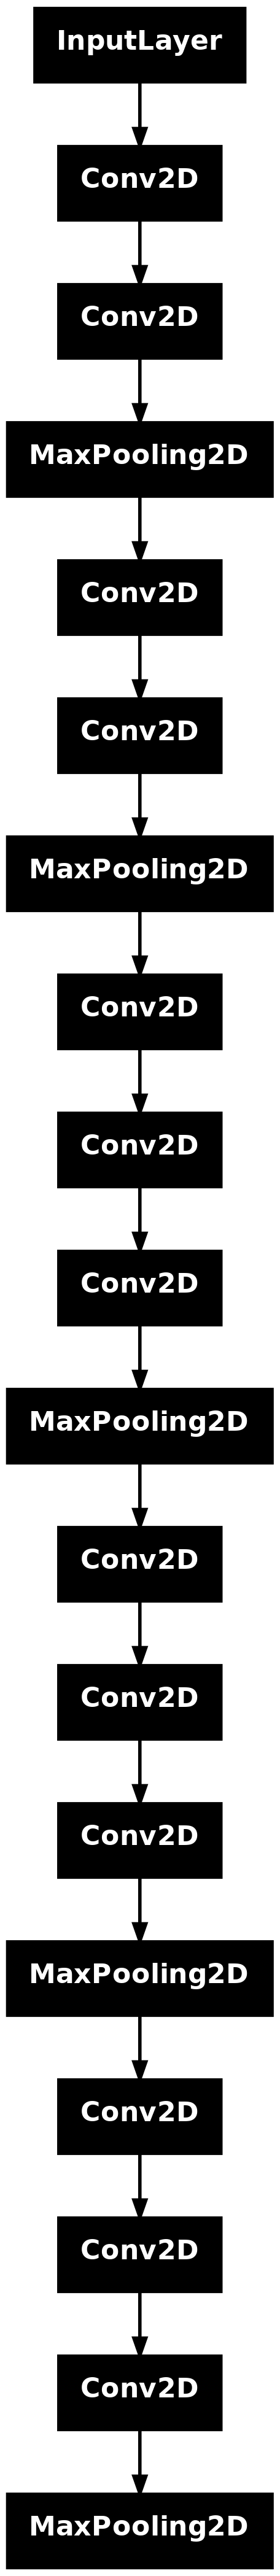

In [9]:
tf.keras.utils.plot_model(conv_base_VGG16)

In [6]:
#Unfreezing the lats 8 layers
for layer in conv_base_VGG16.layers[-8:]:
    layer.trainable = True

In [7]:
#Extract features
train_features, train_labels = extract_features(conv_base_VGG16, train_ds)
val_features, val_labels = extract_features(conv_base_VGG16, val_ds)
test_features, test_labels = extract_features(conv_base_VGG16, test_ds)

I0000 00:00:1741699773.396380 2235796 service.cc:148] XLA service 0x7f13dc004370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741699773.396403 2235796 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-03-11 14:29:33.404267: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741699773.454698 2235796 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-11 14:29:33.726398: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backen

In [8]:
#Flatering features to vonverto to a 2D array for machine learning algorithms
train_features = train_features.reshape(train_features.shape[0], -1) #[0] number of samples in the dataset and -1 indicated to Numpy to 
#automatically calculate the size of the second dimension to preserve the total number of elements.
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

*By default LGBM model*

In [9]:
lgb = LGBMClassifier(colsample_bytree=0.9, max_depth=5, metric='multi_logloss', n_estimators=1000, num_classes=2, 
                     objective='multiclass', reg_alpha=0.01, reg_lambda=0.01, subsample=0.8)

lgb.fit(train_features, np.ravel(train_labels))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.442387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2565102
[LightGBM] [Info] Number of data points in the train set: 2455, number of used features: 17559
[LightGBM] [Info] Start training from score -0.684630
[LightGBM] [Info] Start training from score -0.701738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

LGBMClassifier(colsample_bytree=0.9, max_depth=5, metric='multi_logloss',
               n_estimators=1000, num_classes=2, objective='multiclass',
               reg_alpha=0.01, reg_lambda=0.01, subsample=0.8)

Accuracy in test: 0.8044328552803129
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81       387
         1.0       0.81      0.79      0.80       380

    accuracy                           0.80       767
   macro avg       0.80      0.80      0.80       767
weighted avg       0.80      0.80      0.80       767



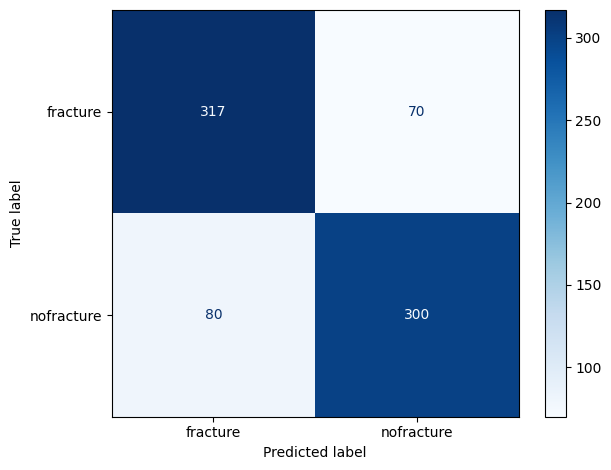

In [10]:
#Evaluating the model
test_predictions = lgb.predict(test_features)
print("Accuracy in test:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.8817


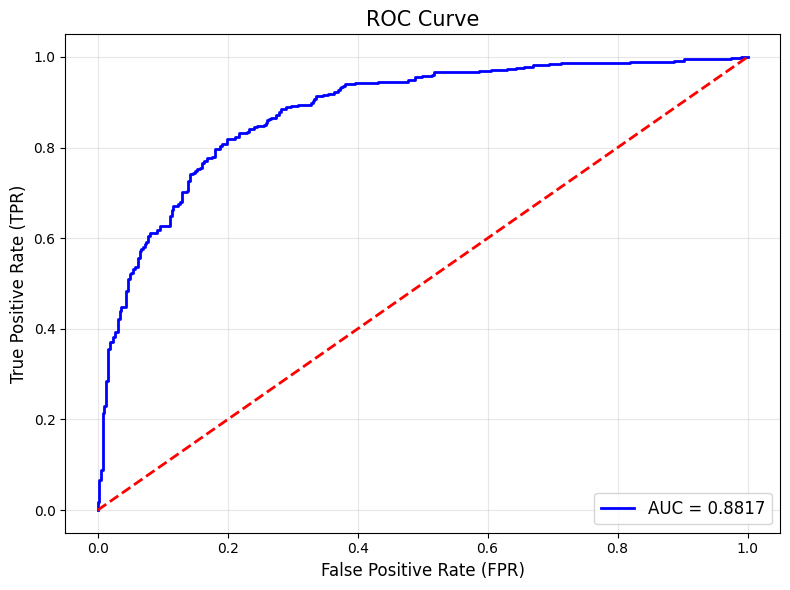

In [11]:
#Obtaining probability for positive class (1)
test_probabilities = lgb.predict_proba(test_features)[:, 1]

# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_probabilities)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

----------------

*Changing class probabilities*

In [27]:
# Obtaining probabilities for class 1 (nofracture)
test_probabilities = lgb.predict_proba(test_features)[:, 1]

#Applying threshold
threshold = 0.51
test_pred = (test_probabilities >= threshold).astype(int)

Accuracy in test: 0.803129074315515
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81       387
         1.0       0.81      0.79      0.80       380

    accuracy                           0.80       767
   macro avg       0.80      0.80      0.80       767
weighted avg       0.80      0.80      0.80       767



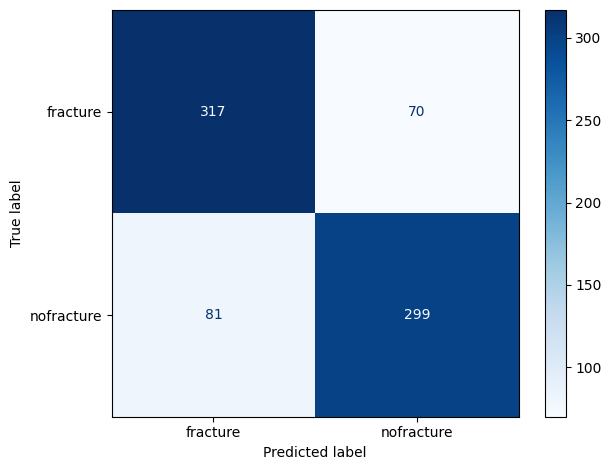

In [28]:
#Evaluating the model
print("Accuracy in test:", accuracy_score(test_labels, test_pred))
print(classification_report(test_labels, test_pred))

cm = confusion_matrix(test_labels, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.8030


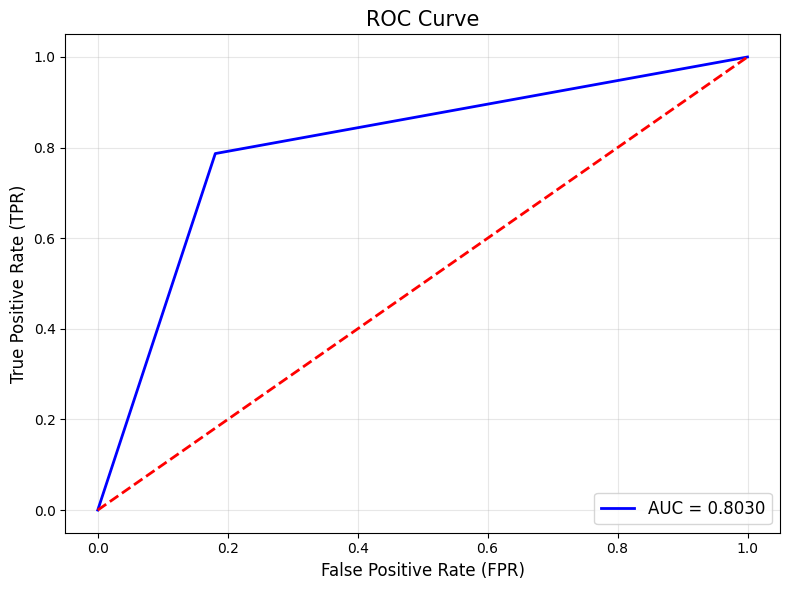

In [29]:
# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_pred)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Obtaining probabilities for class 1 (nofracture)
test_probabilities = lgb.predict_proba(test_features)[:, 1]

#Applying threshold
threshold = 0.55
test_pred = (test_probabilities >= threshold).astype(int)

Accuracy in test: 0.8018252933507171
              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81       387
         1.0       0.81      0.78      0.80       380

    accuracy                           0.80       767
   macro avg       0.80      0.80      0.80       767
weighted avg       0.80      0.80      0.80       767



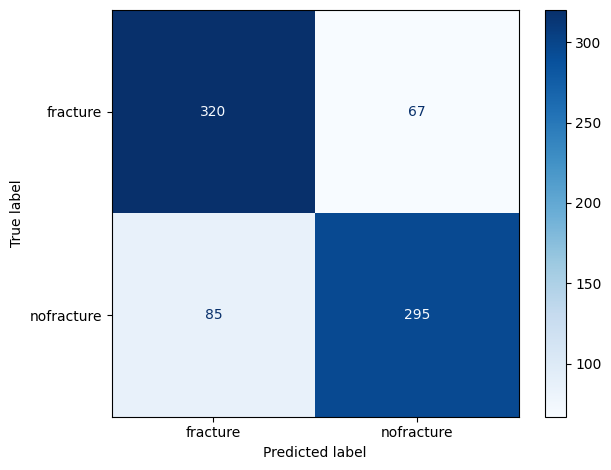

In [31]:
#Evaluating the model
print("Accuracy in test:", accuracy_score(test_labels, test_pred))
print(classification_report(test_labels, test_pred))

cm = confusion_matrix(test_labels, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.8016


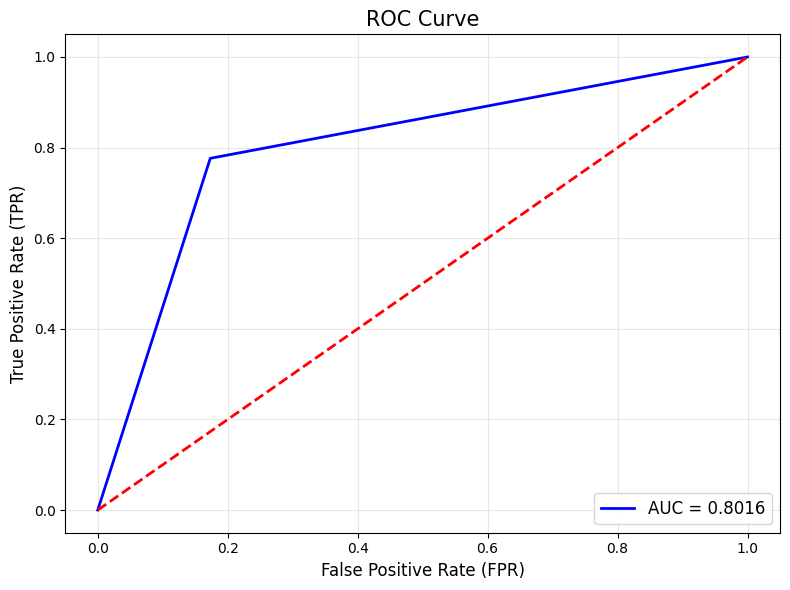

In [32]:
# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_pred)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Obtaining probabilities for class 1 (nofracture)
test_probabilities = lgb.predict_proba(test_features)[:, 1]

#Applying threshold
threshold = 0.6
test_pred = (test_probabilities >= threshold).astype(int)

Accuracy in test: 0.8018252933507171
              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81       387
         1.0       0.82      0.77      0.79       380

    accuracy                           0.80       767
   macro avg       0.80      0.80      0.80       767
weighted avg       0.80      0.80      0.80       767



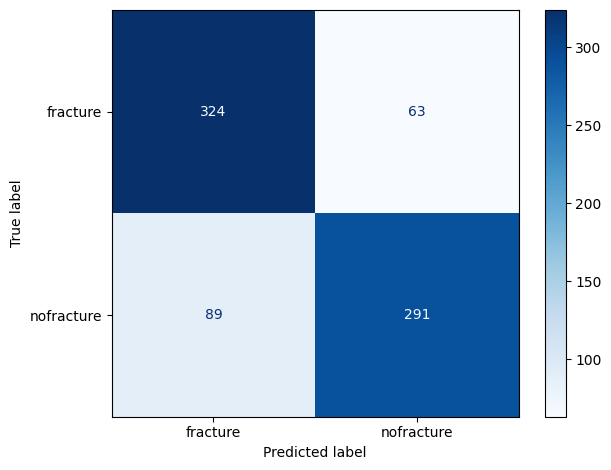

In [13]:
#Evaluating the model
print("Accuracy in test:", accuracy_score(test_labels, test_pred))
print(classification_report(test_labels, test_pred))

cm = confusion_matrix(test_labels, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.8015


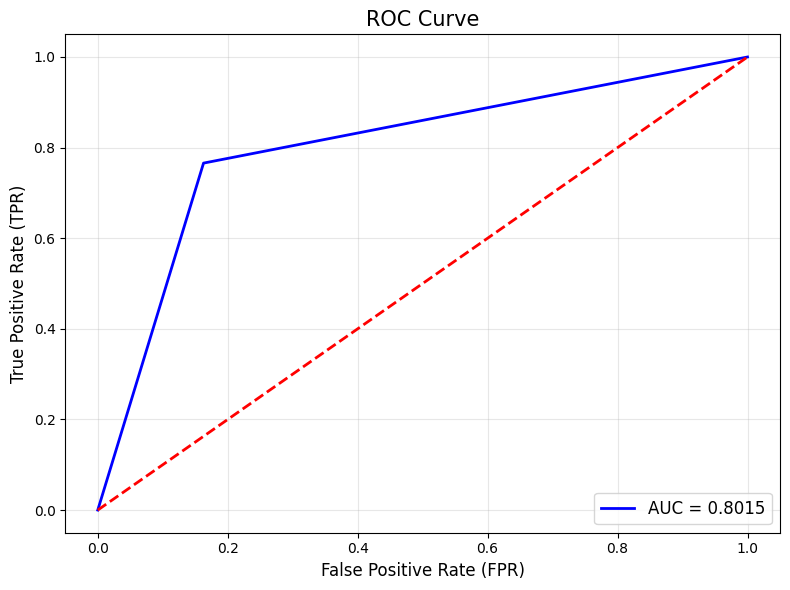

In [14]:
# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_pred)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

-------------

In [15]:
# Obtaining probabilities for class 1 (nofracture)
test_probabilities = lgb.predict_proba(test_features)[:, 1]

#Applying threshold
threshold = 0.7
test_pred = (test_probabilities >= threshold).astype(int)

Accuracy in test: 0.7861799217731421
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80       387
         1.0       0.83      0.71      0.77       380

    accuracy                           0.79       767
   macro avg       0.79      0.79      0.78       767
weighted avg       0.79      0.79      0.78       767



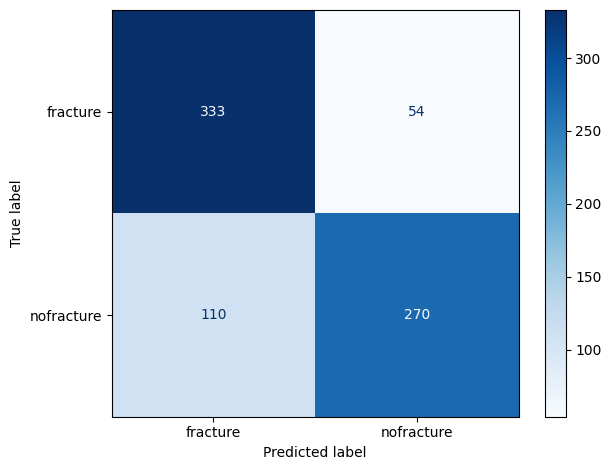

In [16]:
#Evaluating the model
print("Accuracy in test:", accuracy_score(test_labels, test_pred))
print(classification_report(test_labels, test_pred))

cm = confusion_matrix(test_labels, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.7855


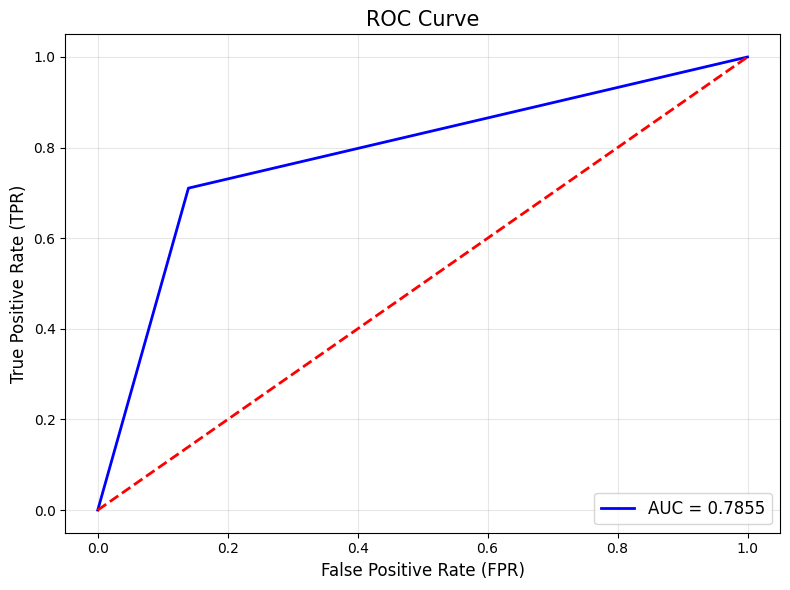

In [17]:
# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_pred)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

-----------

In [18]:
# Obtaining probabilities for class 1 (nofracture)
test_probabilities = lgb.predict_proba(test_features)[:, 1]

#Applying threshold
threshold = 0.71
test_pred = (test_probabilities >= threshold).astype(int)

Accuracy in test: 0.7848761408083442
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80       387
         1.0       0.83      0.71      0.76       380

    accuracy                           0.78       767
   macro avg       0.79      0.78      0.78       767
weighted avg       0.79      0.78      0.78       767



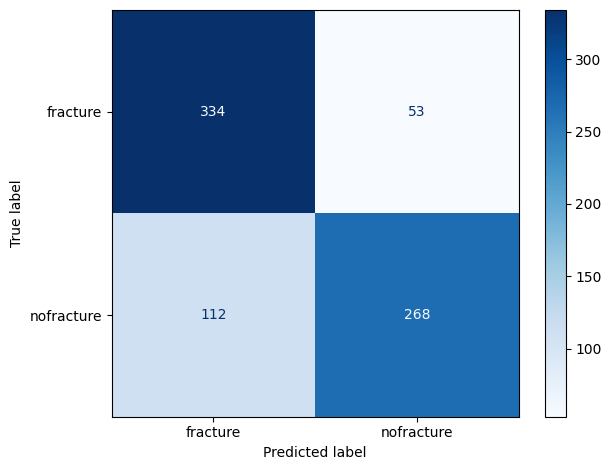

In [19]:
#Evaluating the model
print("Accuracy in test:", accuracy_score(test_labels, test_pred))
print(classification_report(test_labels, test_pred))

cm = confusion_matrix(test_labels, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.7842


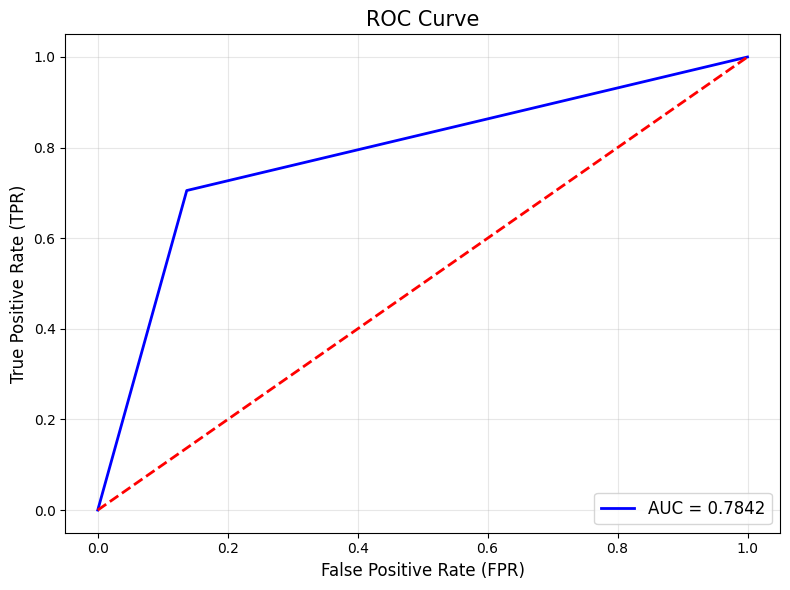

In [20]:
# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_pred)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

--------

In [21]:
# Obtaining probabilities for class 1 (nofracture)
test_probabilities = lgb.predict_proba(test_features)[:, 1]

#Applying threshold
threshold = 0.72
test_pred = (test_probabilities >= threshold).astype(int)

Accuracy in test: 0.7848761408083442
              precision    recall  f1-score   support

         0.0       0.75      0.87      0.80       387
         1.0       0.84      0.70      0.76       380

    accuracy                           0.78       767
   macro avg       0.79      0.78      0.78       767
weighted avg       0.79      0.78      0.78       767



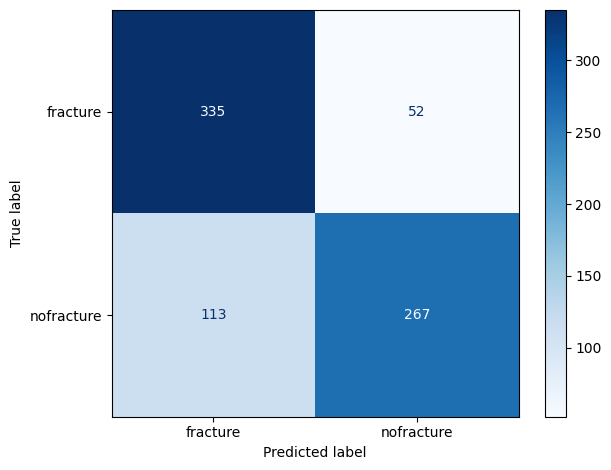

In [22]:
#Evaluating the model
print("Accuracy in test:", accuracy_score(test_labels, test_pred))
print(classification_report(test_labels, test_pred))

cm = confusion_matrix(test_labels, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.7841


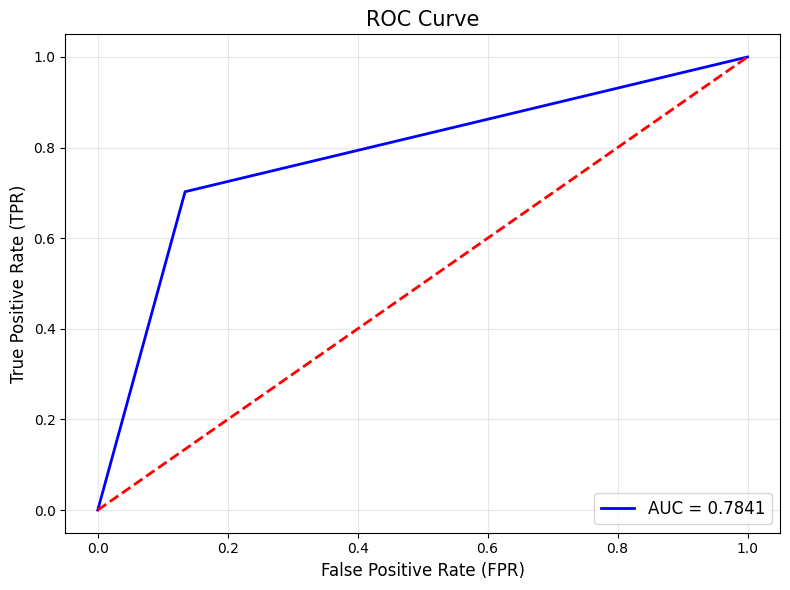

In [23]:
# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_pred)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

------

In [24]:
# Obtaining probabilities for class 1 (nofracture)
test_probabilities = lgb.predict_proba(test_features)[:, 1]

#Applying threshold
threshold = 0.75
test_pred = (test_probabilities >= threshold).astype(int)

Accuracy in test: 0.7770534550195567
              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80       387
         1.0       0.84      0.68      0.75       380

    accuracy                           0.78       767
   macro avg       0.79      0.78      0.77       767
weighted avg       0.79      0.78      0.77       767



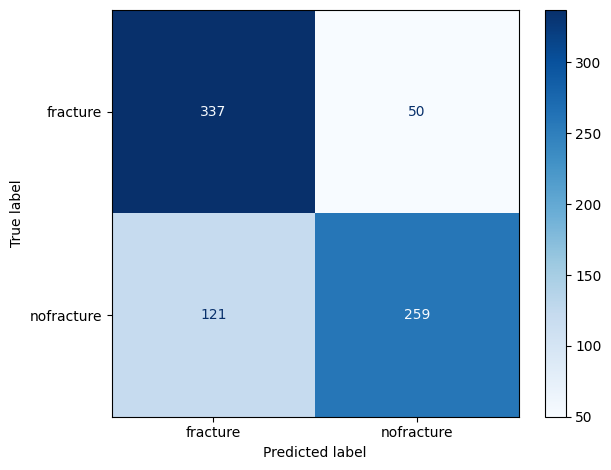

In [25]:
#Evaluating the model
print("Accuracy in test:", accuracy_score(test_labels, test_pred))
print(classification_report(test_labels, test_pred))

cm = confusion_matrix(test_labels, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.7762


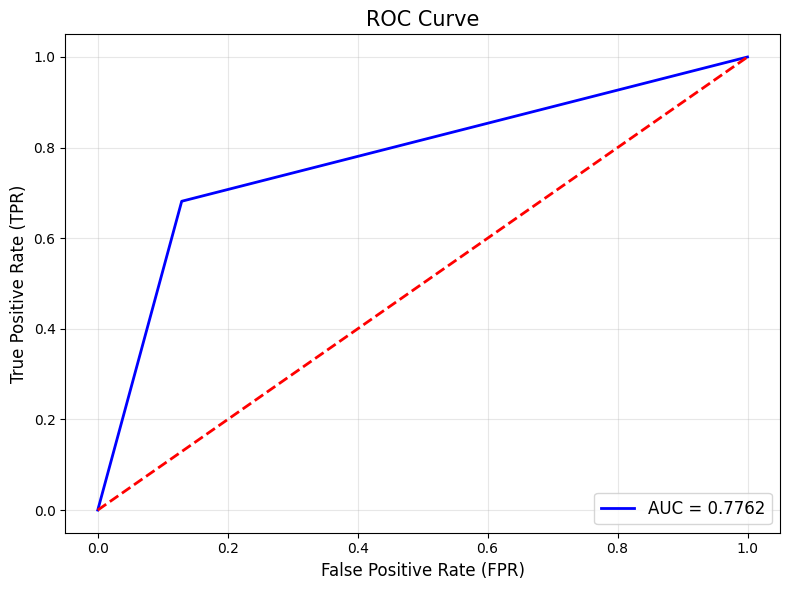

In [26]:
# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_pred)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()